In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
file_dir = '/Users/ilan/git/movies-etl/'

In [3]:
with open(f'{file_dir}/wikipedia-movies.json',mode='r') as file:
    wiki_movies_raw = json.load(file)

In [49]:
kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}ratings.csv')

In [50]:
# Check the data
kaggle_metadata.sample(n=5)
ratings.tail()

,userId,movieId,rating,timestamp
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990
26024288,270896,71878,2.0,1257031858


In [6]:
# Check for issues with an immediate import
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

# too many columns

In [9]:
# Pull out only movies with a Director or Directed by and an IMDB link
wiki_movies = [movie for movie in wiki_movies_raw 
               if('Director' in movie or 'Directed by' in movie)
               and 'imdb_link' in movie
               and 'No. of episodes' not in movie]
wiki_movies_df = pd.DataFrame(wiki_movies)

#some rows and columns removed
sorted(wiki_movies_df.columns.tolist())



['Adaptation by',
 'Also known as',
 'Animation by',
 'Arabic',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cantonese',
 'Chinese',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Country of origin',
 'Created by',
 'Directed by',
 'Director',
 'Distributed by',
 'Distributor',
 'Edited by',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'French',
 'Genre',
 'Hangul',
 'Hebrew',
 'Hepburn',
 'Japanese',
 'Label',
 'Language',
 'Length',
 'Literally',
 'Mandarin',
 'McCune–Reischauer',
 'Music by',
 'Narrated by',
 'Original language(s)',
 'Original network',
 'Original release',
 'Original title',
 'Picture format',
 'Polish',
 'Preceded by',
 'Produced by',
 'Producer',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Productioncompanies ',
 'Productioncompany ',
 'Recorded',
 'Release date',
 'Released',
 'Revised Romanization',
 'Romanized',
 'Running time',
 'Russian',
 'Screen story by',
 'Screenplay by',
 'Simplifie

In [10]:
def clean_movie(movie):
    
    
    movie = dict(movie)  #Create a non-destructive copy

    alt_titles = {}
    for language in ['Arabic', 'Cantonese', 'Chinese', 'French', 'Hangul', 'Hebrew', 'Hepburn', 'Japanese', 
                     'Literally', 'Mandarin', 'McCune–Reischauer', 'Original title', 'Polish',  'Revised Romanization', 'Romanized', 'Russian', 'Simplified', 'Traditional', 'Yiddish']:
        if language in movie:
            alt_titles[language] = movie[language]
            movie.pop(language)
    if len(alt_titles) > 0:
        movie["alt_titles"] = alt_titles
        
    # Merge column names    
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
            
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)') 
    
    return movie
    
    

In [11]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
wiki_movies_df["imdb_link"].head(10)

0    https://www.imdb.com/title/tt0098987/
1    https://www.imdb.com/title/tt0098994/
2    https://www.imdb.com/title/tt0099005/
3    https://www.imdb.com/title/tt0099012/
4    https://www.imdb.com/title/tt0099018/
5    https://www.imdb.com/title/tt0099026/
6    https://www.imdb.com/title/tt0099028/
7    https://www.imdb.com/title/tt0101326/
8    https://www.imdb.com/title/tt0099037/
9    https://www.imdb.com/title/tt0099039/
Name: imdb_link, dtype: object

In [12]:
#use regex to get the imdb_id from the url
q = "(?:https:\/\/www.imdb.com\/title\/)(tt\d{7})"
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(q)

In [13]:
# Remove duplicates based on imdb_id 
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))

# remove columns with more than 10% null values in them. 
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

7076
7030


In [14]:
box_office = wiki_movies_df['Box office'].dropna()
box_office

0          $21.4 million
1           $2.7 million
2            $57,718,089
3             $7,331,647
4       $6,939,946 (USA)
              ...       
7070       $19.4 million
7071       $41.9 million
7072       $76.1 million
7073       $38.4 million
7074        $5.5 million
Name: Box office, Length: 5484, dtype: object

In [15]:
box_office[box_office.map(lambda x : type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [16]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [18]:
# A dollar sign
# An arbitrary (but non-zero) number of digits
# An optional decimal point
# An arbitrary (but possibly zero) number of more digits
# A space (maybe more than one)
# The word "million" or "billion"

# Remove the first part of a range of values to leave only one value.
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

form_one = r'\$\s*\d+\.?\d*\s*.[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi?on)'
match_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
match_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)
box_office[~match_form_two & ~match_form_one]

600                      $5000 (US)
1070                     35,254,617
1480                     £3 million
1865                   ¥1.1 billion
2032                            N/A
2091                           $309
2665    926,423 admissions (France)
3631                            TBA
3879       CN¥3.650 million (China)
4116                     £7,385,434
4306                            $30
4561        $45.2k (only in Turkey)
5447                          £2.56
5784                       413 733$
6013                        Unknown
6369                          $111k
6370                           $588
6593                 less than $372
6843                        8 crore
6959                  $395\nmillion
Name: Box office, dtype: object

In [19]:
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [20]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan
    
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
        # remove dollar sign and " million"
        s = re.sub('\$|\s*|[a-zA-Z]','', s)
        # convert to float and multiply by a million
        value = float(s) * 10**6
        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
        # remove dollar sign and " billion"
        s = re.sub('\$|\s*|[a-zA-Z]','', s)        
        # convert to float and multiply by a billion
        value = float(s) * 10**9
        # return value
        return value
    
    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\sbilli?on)', s, flags=re.IGNORECASE):
        # remove dollar sign and commas
        s = re.sub('\$|,','', s)
        
        # convert to float
        value = float(s) 
        # return value
        return value
    
    # otherwise, return NaN
    else:
        return np.nan

In [21]:
box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7070    19400000.0
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
Name: 0, Length: 5484, dtype: float64

In [22]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [23]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)
wiki_movies_df[['box_office']]

,box_office
0,21400000.0
1,2700000.0
2,57718089.0
3,7331647.0
4,6939946.0
...,...
7071,41900000.0
7072,76100000.0
7073,38400000.0
7074,5500000.0


In [24]:
# get rows with a budget, create a new series and leave out the nulls.
budget = wiki_movies_df['Budget'].dropna()

# Convert any lists to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

# Remove values between a $ and a hyphen.  (budget ranges)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)


In [25]:
budget_match_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
budget_match_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget = budget.str.replace(r'\[\d+\]\s*', '')
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Budget', axis=1, inplace=True)

/Users/ilan/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [27]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [28]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,"November 8, 2018"
7074,"August 31, 2018"


In [29]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [30]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [31]:
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [33]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [34]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [62]:
kaggle_metadata.dtypes

belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                       bool
vote_average             float64
vote_count               float64
dtype: object

In [51]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [56]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [57]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [59]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [61]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [69]:
ratings.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [70]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [71]:
ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,2015-03-09 22:52:09
1,1,147,4.5,2015-03-09 23:07:15
2,1,858,5.0,2015-03-09 22:52:03
3,1,1221,5.0,2015-03-09 22:52:26
4,1,1246,5.0,2015-03-09 22:52:36
...,...,...,...,...
26024284,270896,58559,5.0,2009-10-31 23:26:04
26024285,270896,60069,5.0,2009-10-31 23:33:52
26024286,270896,63082,4.5,2009-10-31 23:29:24
26024287,270896,64957,4.5,2009-11-01 00:06:30


count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

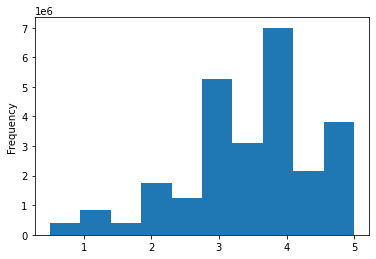

In [73]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()